In [ ]:
!pip install autogluon
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install imodels
!pip install --upgrade interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━

In [ ]:
import pandas
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import itertools, warnings
import textwrap
from pprint import pprint
from sklearn.metrics import classification_report, confusion_matrix
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from imodels import FIGSClassifier
from imodels.tree.viz_utils import extract_sklearn_tree_from_figs
from sklearn.tree import export_text




In [ ]:
# ──────────────────────────────────────────────────────────────
# 0.  Connect to disk if on colab, not necessary on local.
# ──────────────────────────────────────────────────────────────
import os
from google.colab import drive
drive.mount('/content/drive')

csv_folder = '/content/drive/MyDrive/Leakage'
print("Files in the CSV folder:", os.listdir(csv_folder))


Mounted at /content/drive
Files in the CSV folder: ['new_features_tube.csv', 'new_features_vent.csv', 'new_features_all.csv', 'new_features_all_train.csv', 'new_features_all_test.csv', 'normalized_train.csv', 'normalized_test.csv', 'processed_val.csv', 'processed_train.csv', 'processed_test.csv', 'leakage_discretized.yaml']


In [ ]:
# ──────────────────────────────────────────────────────────────
# 1.  Split the data to train, test, val
# ──────────────────────────────────────────────────────────────

def split_dataset(df, showsize):
    df = df.drop(columns=["Path"]) # delete paths column
    train_data = df.sample(frac=0.8, random_state=25)
    test_data = df.drop(train_data.index) # the rest of the files in the original df after picking out the train_data
    y_test = test_data["isLeak"]
    test_data = test_data.drop(columns=["isLeak"]) # delete isLeak column to prove there is no cheating
    if showsize == True:
        print('Train size: ' + str(len(train_data)- int(len(train_data)*0.1)) + ', Validation size: ' + str(int(len(train_data)*0.1)) + ', Test size: ' + str(len(test_data)))
    return train_data, test_data, y_test


"""
    This part of the program requires action by the user. The user needs to define which
"""

df_tube = pandas.read_csv('/content/drive/MyDrive/Leakage/new_features_tube.csv')
df_vent = pandas.read_csv('/content/drive/MyDrive/Leakage/new_features_vent.csv')
df_both = pandas.concat([df_vent, df_tube], axis=0, ignore_index=True)


"""
     Uncomment all the three rows underneeth in order to run the initial feature combination with 18 features
"""
df_tube = df_tube.drop(columns=['RMS 4-20kHz'])
df_vent = df_vent.drop(columns=['RMS 4-20kHz'])
df_both = df_both.drop(columns=['RMS 4-20kHz'])

"""
     Uncomment all the three rows underneeth in order to run the alternative feature combination with 12 features
"""
#df_tube = df_tube.drop(columns=['Bandwidth', 'RMS 4-8kHz', 'RMS 8-12kHz', 'RMS 12-16kHz', 'RMS 16-20kHz'])
#df_vent = df_vent.drop(columns=['Bandwidth', 'RMS 4-8kHz', 'RMS 8-12kHz', 'RMS 12-16kHz', 'RMS 16-20kHz'])
#df_both = df_both.drop(columns=['Bandwidth', 'RMS 4-8kHz', 'RMS 8-12kHz', 'RMS 12-16kHz', 'RMS 16-20kHz', 'Centroid 4-8kHz', 'RMS 4-20kHz'])

"""
    Define which of the dataframes that shall be used as input to the ML algorithms. Either "df_tube", "dt_vent" or "df_both".
"""
df = df_vent

train_data, test_data, y_test = split_dataset(df, True)

Train size: 1244, Validation size: 138, Test size: 346


In [ ]:


# ──────────────────────────────────────────────────────────────
# 2.  Train EBM
# ──────────────────────────────────────────────────────────────
def train_ebm(train_data,
              interactions=10,
              max_bins=32,
              learning_rate=0.01,
              random_state=42):
    """
    Train an Explainable Boosting Machine on the vent/tube/both dataset.
    Returns fitted ebm object.
    """
    X_train = train_data.drop(columns=['isLeak'])  # features only
    y_train = train_data['isLeak']                 # labels
    ebm = ExplainableBoostingClassifier(
        interactions=interactions,
        max_bins=max_bins,
        learning_rate=learning_rate,
        random_state=random_state
    )
    ebm.fit(X_train, y_train)
    return ebm




In [ ]:

# ──────────────────────────────────────────────────────────────
# 3.  Test + basic report
# ──────────────────────────────────────────────────────────────
def test_ebm(ebm, test_data, y_test):
    """
    Predict on test set and print precision/recall/F1.
    Returns the ndarray of predictions.
    """
    y_pred = ebm.predict(test_data)
    print(classification_report(y_test, y_pred))
    return y_pred


In [ ]:
# ──────────────────────────────────────────────────────────────
# 4.  Confusion‑matrix helper
# ──────────────────────────────────────────────────────────────
def create_confusion_matrix_ebm(y_test, y_pred):
    ax = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.1)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted', fontdict={'size': 15})
    ax.set_ylabel('Actual',   fontdict={'size': 15})
    ax.set_title('Confusion Matrix ‑ EBM', fontsize=16)
    ax.xaxis.set_ticklabels(['No Leakage', 'Leakage'])
    ax.yaxis.set_ticklabels(['No Leakage', 'Leakage'])
    plt.show()

In [ ]:
# ──────────────────────────────────────────────────────────────
# 5.  Global & local explanation dashboards (Jupyter)
# ──────────────────────────────────────────────────────────────
def get_ebm_global(ebm):
    """
    Launch InterpretML HTML dashboard.
    """
    global_exp = ebm.explain_global(name='Leak‑Detection EBM')
    show(global_exp)                 # interactive PDPs + interactions

def show_ebm_local(ebm, test_data, y_test, label):
    """
    Explain one prediction by original index label.
    """
    exp = ebm.explain_local(test_data.loc[[label]], y_test.loc[[label]])
    show(exp)


Train size: 2627, Validation size: 291, Test size: 730
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       373
           1       0.97      0.92      0.95       357

    accuracy                           0.95       730
   macro avg       0.95      0.95      0.95       730
weighted avg       0.95      0.95      0.95       730



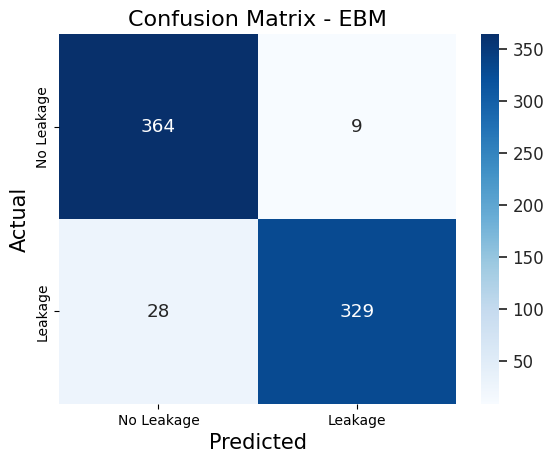

/usr/local/lib/python3.11/dist-packages/plotly/basedatatypes.py:2314: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.11/dist-packages/plotly/basedatatypes.py:2314: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.11/dist-packages/plotly/basedatatypes.py:2314: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.11/dist-packages/plotly/basedatatypes.py:2314: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.11/dist-packages/plotly/based

In [ ]:

warnings.filterwarnings(
    action="ignore",
    message=r"Pickle, copy, and deepcopy support will be removed from itertools",
    category=DeprecationWarning,
)


train_data, test_data, y_test = split_dataset(df, True)

ebm = train_ebm(train_data)

y_pred = test_ebm(ebm, test_data, y_test)

create_confusion_matrix_ebm(y_test, y_pred)

get_ebm_global(ebm)
#show_ebm_local(ebm, test_data, y_test, label=96)


In [ ]:
# ------------------------------------------------------------------
# Function to inspect the samples found matching the constraints.
# Plots local explanations
# ------------------------------------------------------------------

def inspect_samples(labels):
    for lab in labels:
        print("─" * 80)
        print(f"Requested label: {lab}")

        if lab not in test_data.index:
            print(f"label {lab} not found in test_data — skip")
            continue


        feats = test_data.loc[lab]
        true  = y_test.loc[lab]
        pred  = ebm.predict(test_data.loc[[lab]])[0]

        print(f"found  →  true y = {true},  model y = {pred}\n")
        print(feats.to_string())


        show_ebm_local(ebm, test_data, y_test, label=lab)


inspect_samples([96, 1291, 25, 473, 1375])





────────────────────────────────────────────────────────────────────────────────
Requested label: 96
found  →  true y = 1,  model y = 1

Mic                  1.000000
Bandwidth            0.940506
Rolloff              0.964483
Flatness             0.257286
Centroid 0-4kHz      0.370245
Centroid 4-8kHz      0.315126
Centroid 8-12kHz     0.396954
Centroid 12-16kHz    0.800215
Centroid 16-20kHz    0.386888
Centroid 20-24kHz    0.910987
RMS 0-4kHz           0.131734
RMS 4-8kHz           0.098080
RMS 8-12kHz          0.091091
RMS 12-16kHz         0.094719
RMS 16-20kHz         0.092482
RMS 20-24kHz         0.167828
PSD >20kHz           0.027582
MAX_AMP >20kHz       0.165104


────────────────────────────────────────────────────────────────────────────────
Requested label: 1291
found  →  true y = 1,  model y = 1

Mic                  2.000000
Bandwidth            0.297214
Rolloff              0.233473
Flatness             0.063954
Centroid 0-4kHz      0.291525
Centroid 4-8kHz      0.249708
Centroid 8-12kHz     0.438321
Centroid 12-16kHz    0.371893
Centroid 16-20kHz    0.607560
Centroid 20-24kHz    0.619256
RMS 0-4kHz           0.132153
RMS 4-8kHz           0.087826
RMS 8-12kHz          0.076772
RMS 12-16kHz         0.042298
RMS 16-20kHz         0.040984
RMS 20-24kHz         0.047126
PSD >20kHz           0.002077
MAX_AMP >20kHz       0.047852


────────────────────────────────────────────────────────────────────────────────
Requested label: 25
found  →  true y = 0,  model y = 0

Mic                  1.000000
Bandwidth            0.344273
Rolloff              0.237860
Flatness             0.119433
Centroid 0-4kHz      0.450543
Centroid 4-8kHz      0.055498
Centroid 8-12kHz     0.415768
Centroid 12-16kHz    0.428801
Centroid 16-20kHz    0.609045
Centroid 20-24kHz    0.594663
RMS 0-4kHz           0.994181
RMS 4-8kHz           0.859483
RMS 8-12kHz          0.792549
RMS 12-16kHz         0.351915
RMS 16-20kHz         0.346575
RMS 20-24kHz         0.098386
PSD >20kHz           0.010970
MAX_AMP >20kHz       0.193071


────────────────────────────────────────────────────────────────────────────────
Requested label: 473
found  →  true y = 1,  model y = 1

Mic                  1.000000
Bandwidth            0.881956
Rolloff              0.943409
Flatness             0.125875
Centroid 0-4kHz      0.400290
Centroid 4-8kHz      0.252564
Centroid 8-12kHz     0.393889
Centroid 12-16kHz    0.710903
Centroid 16-20kHz    0.287236
Centroid 20-24kHz    0.930786
RMS 0-4kHz           0.532344
RMS 4-8kHz           0.410250
RMS 8-12kHz          0.456544
RMS 12-16kHz         0.411112
RMS 16-20kHz         0.353757
RMS 20-24kHz         0.545569
PSD >20kHz           0.293113
MAX_AMP >20kHz       0.483995


────────────────────────────────────────────────────────────────────────────────
Requested label: 1375
found  →  true y = 0,  model y = 0

Mic                  4.000000
Bandwidth            0.073526
Rolloff              0.111185
Flatness             0.023800
Centroid 0-4kHz      0.357997
Centroid 4-8kHz      0.184174
Centroid 8-12kHz     0.446059
Centroid 12-16kHz    0.226272
Centroid 16-20kHz    0.602723
Centroid 20-24kHz    0.101483
RMS 0-4kHz           0.155163
RMS 4-8kHz           0.157123
RMS 8-12kHz          0.133637
RMS 12-16kHz         0.049048
RMS 16-20kHz         0.031894
RMS 20-24kHz         0.004313
PSD >20kHz           0.000041
MAX_AMP >20kHz       0.027453


────────────────────────────────────────────────────────────────────────────────
Requested label: 1759
found  →  true y = 0,  model y = 1

Mic                  4.000000
Bandwidth            0.316592
Rolloff              0.172142
Flatness             0.100762
Centroid 0-4kHz      0.679178
Centroid 4-8kHz      0.137545
Centroid 8-12kHz     0.293747
Centroid 12-16kHz    0.392377
Centroid 16-20kHz    0.435956
Centroid 20-24kHz    0.760303
RMS 0-4kHz           0.680472
RMS 4-8kHz           0.555154
RMS 8-12kHz          0.518002
RMS 12-16kHz         0.139250
RMS 16-20kHz         0.070286
RMS 20-24kHz         0.048367
PSD >20kHz           0.003761
MAX_AMP >20kHz       0.236301


In [ ]:
import pandas as pd

# ------------------------------------------------------------------
# Helper function to locate specific interesting samples inthe data set.
# If no row matches it reports that fact so you can tweak thresholds.
# ------------------------------------------------------------------
def pick_one(mask: pd.Series, tag: str):
    idxs = test_data.index[mask]
    if len(idxs) == 0:
        print(f"[{tag}]  ✖  no test rows satisfy the condition — try relaxing bounds")
        return None
    chosen = idxs[0]
    print(f"[{tag}]  ✓  found row index {chosen}")
    return chosen





cond1 = (
    (test_data['RMS 20-24kHz']      >= 0.08) &
    (test_data['Centroid 20-24kHz'] >= 0.75) &
    (test_data['RMS 0-4kHz']        <  0.15)
)
idx1 = pick_one(cond1, "sample 1  (HF‑only leak)")


cond2 = (
    (test_data['RMS 20-24kHz'].between(0.04, 0.060, inclusive="both")) &
    (test_data['Centroid 20-24kHz'].between(0.4, 0.62, inclusive="both")) &
    (test_data['RMS 12-16kHz']       < 0.05)
)
idx2 = pick_one(cond2, "sample 2  (mid‑centroid leak)")


cond3 = (
    (test_data['RMS 20-24kHz'] >= 0.05) &
    (test_data['RMS 0-4kHz']   >= 0.70)
)
idx3 = pick_one(cond3, "sample 3  (broadband noise)")


cond4 = (
    (test_data['RMS 20-24kHz']      < 0.01) &
    (test_data['Centroid 20-24kHz'] < 0.20) &
    (test_data['RMS 12-16kHz'].between(0.04, 0.08, inclusive="both"))
)
idx4 = pick_one(cond4, "sample 4  (mid‑band noise)")


cond5 = (
    (test_data['RMS 20-24kHz']      > 0.30) &
    (test_data['Centroid 20-24kHz'] > 0.90)
)
idx5 = pick_one(cond5, "sample 5  (HF tail)")


interesting_indices = {
    "sample1": idx1,
    "sample2": idx2,
    "sample3": idx3,
    "sample4": idx4,
    "sample5": idx5,
}







[sample 1  (HF‑only leak)]  ✓  found row index 96
[sample 2  (mid‑centroid leak)]  ✓  found row index 1291
[sample 3  (broadband noise)]  ✓  found row index 25
[sample 4  (mid‑band noise)]  ✓  found row index 1375
[sample 5  (HF tail)]  ✓  found row index 473


In [ ]:
# ------------------------------------------------------------------
# Helper function to locate wrong prediction samples
# ------------------------------------------------------------------
fp_mask = (y_pred == 1) & (y_test == 0)  # predicted leak, but actually no leak
fn_mask = (y_pred == 0) & (y_test == 1)  # predicted no leak, but actually leak


if fp_mask.any():
    fp_idx = y_test[fp_mask].index[0]
    print(f"False Positive at index: {fp_idx}")
else:
    print("No false positives found in the test set.")

print("-" * 80)

if fn_mask.any():
    fn_idx = y_test[fn_mask].index[0]
    print(f"False Negative at index: {fn_idx}")

else:
    print("No false negatives found in the test set.")


inspect_samples([1759, 65])

False Positive at index: 1759
--------------------------------------------------------------------------------
False Negative at index: 65
────────────────────────────────────────────────────────────────────────────────
Requested label: 1759
found  →  true y = 0,  model y = 1

Mic                  4.000000
Bandwidth            0.316592
Rolloff              0.172142
Flatness             0.100762
Centroid 0-4kHz      0.679178
Centroid 4-8kHz      0.137545
Centroid 8-12kHz     0.293747
Centroid 12-16kHz    0.392377
Centroid 16-20kHz    0.435956
Centroid 20-24kHz    0.760303
RMS 0-4kHz           0.680472
RMS 4-8kHz           0.555154
RMS 8-12kHz          0.518002
RMS 12-16kHz         0.139250
RMS 16-20kHz         0.070286
RMS 20-24kHz         0.048367
PSD >20kHz           0.003761
MAX_AMP >20kHz       0.236301


────────────────────────────────────────────────────────────────────────────────
Requested label: 65
found  →  true y = 1,  model y = 0

Mic                  1.000000
Bandwidth            0.332537
Rolloff              0.238474
Flatness             0.088614
Centroid 0-4kHz      0.417200
Centroid 4-8kHz      0.090214
Centroid 8-12kHz     0.438486
Centroid 12-16kHz    0.405204
Centroid 16-20kHz    0.581781
Centroid 20-24kHz    0.594386
RMS 0-4kHz           0.983927
RMS 4-8kHz           0.782362
RMS 8-12kHz          0.688343
RMS 12-16kHz         0.310218
RMS 16-20kHz         0.300967
RMS 20-24kHz         0.100547
PSD >20kHz           0.011027
MAX_AMP >20kHz       0.201835


In [ ]:
# ------------------------------------------------------------------
# Script to run model on different configurations, i.e different parameters
# ------------------------------------------------------------------

param_grid = {
    "interactions": [5, 10, 15],
    "max_bins":     [32, 64, 128, 256],
    "learning_rate":[0.01, 0.02, 0.05],
}
datasets = {
    "tube": df_tube,
    "vent": df_vent,
    "both": df_both,
}


run_id = 1
for ds_name, df in datasets.items():
    for interactions, max_bins, lr in itertools.product(

    """
    Script to run training on EBM with various pre defined hyper params.
    """
            param_grid["interactions"],
            param_grid["max_bins"],
            param_grid["learning_rate"]):

        print(f"\n{'─'*70}")
        print(f"Run {run_id}:  dataset = {ds_name}")
        pprint({
            "interactions": interactions,
            "max_bins":     max_bins,
            "learning_rate":lr,
            "random_state": 42,
        }, compact=True)
        print()


        train_data, test_data, y_test = split_dataset(df.copy(), True)


        ebm = train_ebm(train_data,
                         interactions=interactions,
                         max_bins=max_bins,
                         learning_rate=lr,
                         random_state=42)


        y_pred = test_ebm(ebm, test_data, y_test)
        print()
        run_id += 1



──────────────────────────────────────────────────────────────────────
Run 1:  dataset = tube
{'interactions': 5, 'learning_rate': 0.01, 'max_bins': 32, 'random_state': 42}

Train size: 1383, Validation size: 153, Test size: 384
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       195
           1       0.95      0.90      0.93       189

    accuracy                           0.93       384
   macro avg       0.93      0.93      0.93       384
weighted avg       0.93      0.93      0.93       384



──────────────────────────────────────────────────────────────────────
Run 2:  dataset = tube
{'interactions': 5, 'learning_rate': 0.02, 'max_bins': 32, 'random_state': 42}

Train size: 1383, Validation size: 153, Test size: 384
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       195
           1       0.96      0.92      0.94       189

    accuracy                           0.94     

KeyboardInterrupt: 

In [ ]:

def train_figs(train_data, max_rules=15, random_state=42):
    """
    Train a FIGS classifier.
    max_rules = total number of decision rules allowed across *all* trees
                (keeps the model a one‑page read; default 15)
    """
    X_tr = train_data.drop(columns=['isLeak'])
    y_tr = train_data['isLeak']
    figs = FIGSClassifier(max_rules=max_rules,
                          random_state=random_state)
    figs.fit(X_tr, y_tr)
    return figs


def evaluate_figs(figs, test_data, y_test):
    y_pred = figs.predict(test_data)
    print(classification_report(y_test, y_pred))


    ax = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', ax=ax)
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
    ax.set_title('FIGS – Confusion Matrix')
    ax.xaxis.set_ticklabels(['No Leak', 'Leak'])
    ax.yaxis.set_ticklabels(['No Leak', 'Leak'])
    plt.show()
    return y_pred



def print_rules(figs):
    """
    Prints every additive tree inside a fitted FIGS model.
    Works even when FIGS used only a subset of columns.
    """

    feature_names = getattr(figs, "feature_names_in_", None)

    n_classes = len(figs.classes_)
    for i in range(len(figs.trees_)):
        sk_tree, _ = extract_sklearn_tree_from_figs(
            figs,
            tree_num=i,
            n_classes=n_classes,
            with_leaf_predictions=True
        )
        print(f"\nTree #{i+1}")
        print(export_text(
            sk_tree,
            feature_names=feature_names,
            decimals=3
        ))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       180
           1       0.99      0.96      0.98       166

    accuracy                           0.98       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.98      0.98      0.98       346



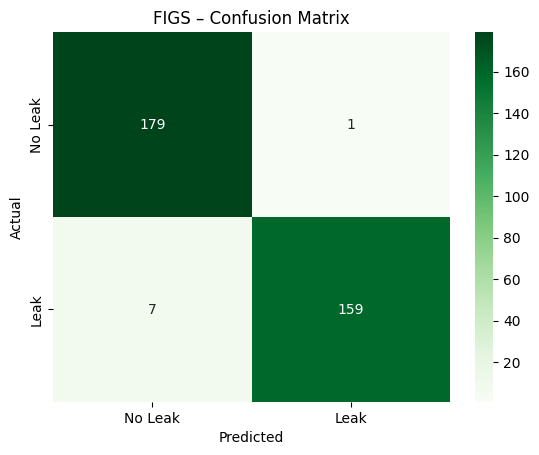


Tree #1
|--- feature_9 <= 0.617
|   |--- feature_15 <= 0.004
|   |   |--- feature_14 <= 0.000
|   |   |   |--- class: 1
|   |   |--- feature_14 >  0.000
|   |   |   |--- feature_4 <= 0.425
|   |   |   |   |--- feature_9 <= 0.577
|   |   |   |   |   |--- feature_8 <= 0.228
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_8 >  0.228
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_9 >  0.577
|   |   |   |   |   |--- feature_10 <= 0.043
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_10 >  0.043
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- feature_4 >  0.425
|   |   |   |   |--- class: 1
|   |--- feature_15 >  0.004
|   |   |--- feature_14 <= 0.032
|   |   |   |--- feature_17 <= 0.083
|   |   |   |   |--- class: 1
|   |   |   |--- feature_17 >  0.083
|   |   |   |   |--- class: 0
|   |   |--- feature_14 >  0.032
|   |   |   |--- feature_13 <= 0.045
|   |   |   |   |--- class: 1
|   |   |   |--- feature_13 >  0.045
|

In [ ]:

figs = FIGSClassifier(max_rules=15,
                      min_impurity_decrease=0,
                      random_state=42)
figs.fit(train_data.drop(columns=['isLeak']),
         train_data['isLeak'])

figs._estimator_type = "classifier"

evaluate_figs(figs, test_data, y_test)

feat_names = ['Mic','Bandwidth','Rolloff','Flatness','Centroid 0-4kHz','Centroid 4-8kHz','Centroid 8-12kHz','Centroid 12-16kHz','Centroid 16-20kHz','Centroid 20-24kHz','RMS 0-4kHz','RMS 4-8kHz','RMS 8-12kHz','RMS 12-16kHz','RMS 16-20kHz','RMS 20-24kHz','PSD >20kHz','MAX_AMP >20kHz','RMS 4-20kHz']


print_rules(figs)


In [ ]:

warnings.filterwarnings(
    action="ignore",
    message=r"Pickle, copy, and deepcopy support will be removed from itertools",
    category=DeprecationWarning,
)


param_grid = {
    "max_rules":            [15, 25, 40],
    "min_impurity_decrease":[0.0, -0.005, -0.01],
    "random_state":         [42],
}
datasets = {"tube": df_tube, "vent": df_vent, "both": df_both}


def evaluate_figs_quiet(figs, X_test, y_test):
    y_pred = figs.predict(X_test)
    print(classification_report(y_test, y_pred))
    return y_pred


run_id = 1
for ds_name, df in datasets.items():
    for max_rules, min_imp, seed in itertools.product(
            param_grid["max_rules"],
            param_grid["min_impurity_decrease"],
            param_grid["random_state"]):

        print(f"\n{'─'*70}")
        print(f"FIGS  Run {run_id}:  dataset = {ds_name}")
        pprint({
            "max_rules":             max_rules,
            "min_impurity_decrease": min_imp,
            "random_state":          seed,
        }, compact=True)
        print()


        train_data, test_data, y_test = split_dataset(df.copy(), True)


        figs = train_figs(train_data,
                          max_rules=max_rules,
                          random_state=seed)
        figs.min_impurity_decrease = min_imp


        _ = evaluate_figs_quiet(figs, test_data, y_test)

        run_id += 1



──────────────────────────────────────────────────────────────────────
FIGS  Run 1:  dataset = tube
{'max_rules': 15, 'min_impurity_decrease': 0.0, 'random_state': 42}

Train size: 1383, Validation size: 153, Test size: 384
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       195
           1       0.91      0.78      0.84       189

    accuracy                           0.86       384
   macro avg       0.86      0.86      0.86       384
weighted avg       0.86      0.86      0.86       384


──────────────────────────────────────────────────────────────────────
FIGS  Run 2:  dataset = tube
{'max_rules': 15, 'min_impurity_decrease': -0.005, 'random_state': 42}

Train size: 1383, Validation size: 153, Test size: 384
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       195
           1       0.91      0.78      0.84       189

    accuracy                           0.86       384
  

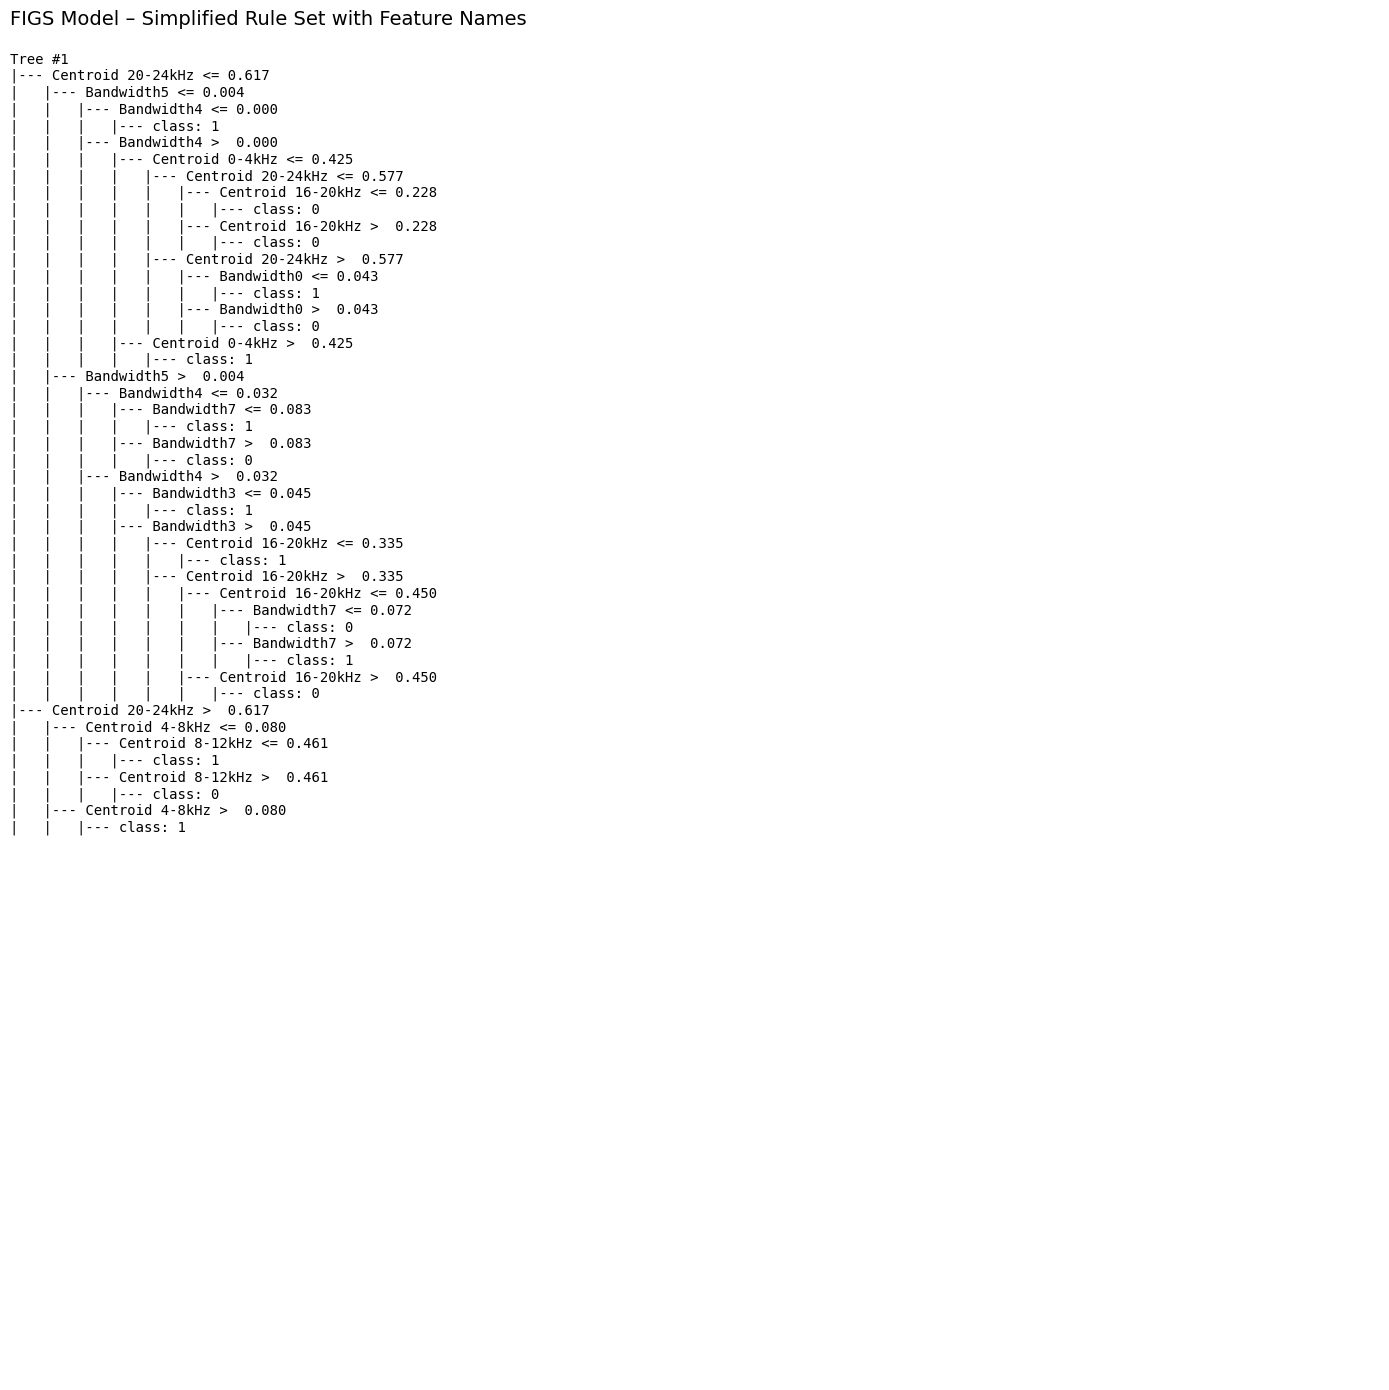

In [ ]:
tree_text = """Tree #1
|--- feature_9 <= 0.617
|   |--- feature_15 <= 0.004
|   |   |--- feature_14 <= 0.000
|   |   |   |--- class: 1
|   |   |--- feature_14 >  0.000
|   |   |   |--- feature_4 <= 0.425
|   |   |   |   |--- feature_9 <= 0.577
|   |   |   |   |   |--- feature_8 <= 0.228
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_8 >  0.228
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_9 >  0.577
|   |   |   |   |   |--- feature_10 <= 0.043
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_10 >  0.043
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- feature_4 >  0.425
|   |   |   |   |--- class: 1
|   |--- feature_15 >  0.004
|   |   |--- feature_14 <= 0.032
|   |   |   |--- feature_17 <= 0.083
|   |   |   |   |--- class: 1
|   |   |   |--- feature_17 >  0.083
|   |   |   |   |--- class: 0
|   |   |--- feature_14 >  0.032
|   |   |   |--- feature_13 <= 0.045
|   |   |   |   |--- class: 1
|   |   |   |--- feature_13 >  0.045
|   |   |   |   |--- feature_8 <= 0.335
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_8 >  0.335
|   |   |   |   |   |--- feature_8 <= 0.450
|   |   |   |   |   |   |--- feature_17 <= 0.072
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_17 >  0.072
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_8 >  0.450
|   |   |   |   |   |   |--- class: 0
|--- feature_9 >  0.617
|   |--- feature_5 <= 0.080
|   |   |--- feature_6 <= 0.461
|   |   |   |--- class: 1
|   |   |--- feature_6 >  0.461
|   |   |   |--- class: 0
|   |--- feature_5 >  0.080
|   |   |--- class: 1
"""

feat_names = ['Mic','Bandwidth','Rolloff','Flatness','Centroid 0-4kHz','Centroid 4-8kHz','Centroid 8-12kHz',
              'Centroid 12-16kHz','Centroid 16-20kHz','Centroid 20-24kHz','RMS 0-4kHz','RMS 4-8kHz','RMS 8-12kHz',
              'RMS 12-16kHz','RMS 16-20kHz','RMS 20-24kHz','PSD >20kHz','MAX_AMP >20kHz','RMS 4-20kHz']

for idx, name in enumerate(feat_names):
    tree_text = tree_text.replace(f"feature_{idx}", name)

wrapped = "\n".join(textwrap.fill(l, 110, subsequent_indent=" " * 4) for l in tree_text.splitlines())

plt.figure(figsize=(14, 14))
plt.axis('off')
plt.text(0, 1, wrapped, va='top', ha='left', fontfamily='monospace', fontsize=10)
plt.title("FIGS Model – Simplified Rule Set with Feature Names", loc='left', fontsize=14, pad=20)
plt.tight_layout()
